## PROJECT 2: INDUSTRIAL PUMP PREDICTIVE MAINTENANCE

**Topic Description:** Build a recurrent neural network (RNN) to predict industrial pump failures based on time-series sensor data. You will develop an LSTM or GRU-based classifier to analyze temporal patterns in sensor readings like vibration, temperature, and pressure.

**Dataset Description:** The dataset consists of 220,320 time-series samples in a CSV file, with 52 continuous sensor measurements. The task is a 3-class classification of the machine's status (NORMAL, BROKEN, RECOVERING). A key challenge is the extreme class imbalance.

**Link:** https://drive.google.com/drive/folders/1nUq198QcmosKNqOQOpheutsdcQTa67VF?usp=share_link


# 1. Introduction


Objective:
This project aims to predict the operational status of an industrial pump using time-series sensor data. The task is formulated as a 3-class classification problem with labels NORMAL, BROKEN, and RECOVERING.

Challenges:

High-dimensional time-series data (52 sensors)

Extreme class imbalance

Long-term temporal dependencies in sensor signals

Approach:
We use a Long Short-Term Memory (LSTM) neural network, which is well-suited for capturing long-range temporal patterns and mitigating vanishing gradient issues in standard RNNs.

# 2. Environment Setup

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score
)
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

tf.config.list_physical_devices('GPU')

[]

In [3]:
# Global constants
LABEL_COL = 'machine_status'
TIMESTAMP_COL = 'timestamp'

In [4]:
# utility functions

def get_sensor_columns(df):
    return [col for col in df.columns if col.startswith('sensor_')]

# sliding window funtion
def create_sequences(X, y, window_size):
    X_seq, y_seq = [], []
    for i in range(len(X) - window_size):
        X_seq.append(X[i:i+window_size])
        y_seq.append(y[i+window_size])
    return np.array(X_seq), np.array(y_seq)

# 3. Load, Data inspection & cleaning

## 3.1. Initial data loading & inspection

In [5]:
DATA_PATH = "sensor.csv"
df = pd.read_csv(DATA_PATH)

df.head()
df.info()
df.describe().T.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,220320.0,110159.500000,63601.049991,0.00000,55079.750000,110159.500000,165239.250000,220319.000000
sensor_00,210112.0,2.372221,0.412227,0.00000,2.438831,2.456539,2.499826,2.549016
sensor_01,219951.0,47.591611,3.296666,0.00000,46.310760,48.133678,49.479160,56.727430
sensor_02,220301.0,50.867392,3.666820,33.15972,50.390620,51.649300,52.777770,56.032990
sensor_03,220301.0,43.752481,2.418887,31.64062,42.838539,44.227428,45.312500,48.220490


In [6]:
df[LABEL_COL].value_counts()
df.isnull().sum().sort_values(ascending=False).head(10)

sensor_15    220320
sensor_50     77017
sensor_51     15383
sensor_00     10208
sensor_07      5451
sensor_08      5107
sensor_06      4798
sensor_09      4595
sensor_01       369
sensor_30       261
dtype: int64

## 3.2. Target label distribution (class imbalance)

Here we inspect the class distribution of `machine_status` to confirm the
extreme class imbalance described in the project specification.


machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


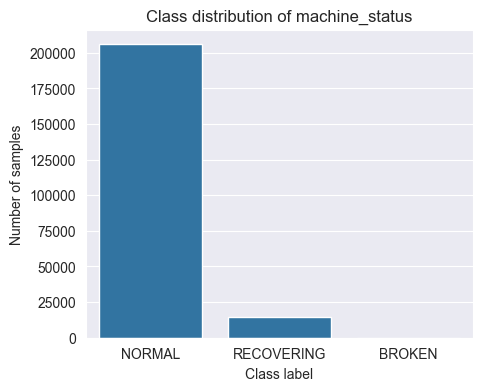

In [7]:
label_counts = df[LABEL_COL].value_counts().sort_values(ascending=False)
print(label_counts)

plt.figure(figsize=(5, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Class distribution of machine_status")
plt.ylabel("Number of samples")
plt.xlabel("Class label")
plt.show()

# 4. Data cleaning

## 4.1. Drop non-informative columns


In [8]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## 4.2 Timestamp processing

In [9]:
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
# LSTM assumes ordered sequences — unsorted timestamps silently break models.

## 4.3. Identify sensor columns

In [10]:
sensor_columns = get_sensor_columns(df)
len(sensor_columns)   # Expected: 52

52

## 4.4. Missing value handling

In [11]:
df[sensor_columns] = df[sensor_columns].ffill().bfill()

## 4.5. Numeric validation

In [12]:
df[sensor_columns] = df[sensor_columns].apply(
    pd.to_numeric, errors='coerce'
)

df[sensor_columns] = df[sensor_columns].ffill().bfill()

## 4.6. Remove constant sensors

In [13]:
constant_sensors = [
    col for col in sensor_columns
    if df[col].nunique() <= 1
]

df.drop(columns=constant_sensors, inplace=True)
print(f"Removed {len(constant_sensors)} constant sensor(s)")

Removed 1 constant sensor(s)


## 4.7 Final sanity check

In [14]:
assert df.isnull().sum().sum() == 0
print("Cleaned shape:", df.shape)

Cleaned shape: (220320, 53)


# 5. Label encoding

In [15]:
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df[LABEL_COL])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
label_mapping

{'BROKEN': np.int64(0), 'NORMAL': np.int64(1), 'RECOVERING': np.int64(2)}

# 6. Feature scaling

In [16]:
sensor_columns = get_sensor_columns(df)

scaler = StandardScaler()
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])

# 7. Sequence generation for LSTM

In [17]:
WINDOW_SIZE = 50

X = df[sensor_columns].values
y = df['label_encoded'].values

X_seq, y_seq = create_sequences(X, y, WINDOW_SIZE)

X_seq.shape, y_seq.shape

((220270, 50, 51), (220270,))

# 8. Train, validation, test split

In [19]:
train_end = int(0.7 * len(X_seq))
val_end = int(0.85 * len(X_seq))

X_train, X_val, X_test = (
    X_seq[:train_end],
    X_seq[train_end:val_end],
    X_seq[val_end:]
)

y_train, y_val, y_test = (
    y_seq[:train_end],
    y_seq[train_end:val_end],
    y_seq[val_end:]
)

## 8.1. Handling class imbalance with class-weighted loss

Because most samples belong to the NORMAL class, we compute class weights
from the training set and use them in the loss function. This penalizes
mistakes on minority classes (BROKEN, RECOVERING) more heavily and helps
the model pay attention to rare but critical failures.

In [20]:
# Compute class weights on the training labels (sequence level)
unique_classes = np.unique(y_train)
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train
)

class_weights = {
    int(cls): float(weight)
    for cls, weight in zip(unique_classes, class_weights_array)
}

print("Class weights:", class_weights)

Class weights: {0: 8566.055555555555, 1: 0.3676918417619944, 2: 3.5686941628477524}


# 9. LSTM model architecture

We use a stacked LSTM with 64 and 32 units respectively. Dropout between
layers acts as regularization. The final Dense layer with softmax outputs
probabilities over the three machine states.


In [21]:
model = Sequential([
    LSTM(64, return_sequences=True,
         input_shape=(WINDOW_SIZE, X_train.shape[2])),
    Dropout(0.3),

    LSTM(32),
    Dropout(0.3),

    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

F:\HANU\Fourth_year\ATI\Final\Final-project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,211 (164.89 KB)

 Trainable params: 42,211 (164.89 KB)

 Non-trainable params: 0 (0.00 B)

# 10. Model training

## 10.1. Optimization settings (training stability)

We use two optimization techniques to stabilize training:

1. **Early stopping** on validation loss to prevent overfitting and stop
   when the model stops improving.
2. **ReduceLROnPlateau** to automatically decrease the learning rate when
   validation loss plateaus, helping the optimizer make finer updates.


In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1e-4,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [23]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    class_weight=class_weights
)

Epoch 1/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.9032 - loss: 1.3895 - val_accuracy: 0.9909 - val_loss: 0.1719 - learning_rate: 0.0010
Epoch 2/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.8954 - loss: 0.6202 - val_accuracy: 0.9794 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 3/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 46s 19ms/step - accuracy: 0.9000 - loss: 0.5687 - val_accuracy: 0.9829 - val_loss: 0.0418 - learning_rate: 0.0010
Epoch 4/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.9139 - loss: 0.5035 - val_accuracy: 0.9903 - val_loss: 0.0800 - learning_rate: 0.0010
Epoch 5/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - accuracy: 0.9175 - loss: 0.3224 - val_accuracy: 0.9905 - val_loss: 0.0400 - learning_rate: 0.0010
Epoch 6/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9297 - loss: 0.3081 - val_accuracy: 0.9888 - val_loss: 0.0859 - learning_rate: 0.0010
Epoch 7/50
2410/2410 ━━━━━━━━━━━━━━━━━━━━ 53s 22ms/step - accura

# 11. Model evaluation

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9357 - loss: 0.1070
Test Accuracy: 0.9357


## 11.1. Classification report

In [25]:
y_pred = np.argmax(model.predict(X_test), axis=1)

labels = np.unique(np.concatenate([y_test, y_pred]))

print(
    classification_report(
        y_test,
        y_pred,
        labels=labels,
        target_names=le.inverse_transform(labels),
        zero_division=0
    )
)

1033/1033 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
              precision    recall  f1-score   support

      BROKEN       0.00      0.00      0.00         0
      NORMAL       1.00      0.94      0.97     33041

    accuracy                           0.94     33041
   macro avg       0.50      0.47      0.48     33041
weighted avg       1.00      0.94      0.97     33041



## 11.2. Imbalanced metrics: balanced accuracy and macro F1


Accuracy alone can be misleading under extreme class imbalance, because
the model can be “right” most of the time just by predicting NORMAL.
Balanced accuracy and macro F1 give equal importance to each class.


In [26]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Balanced accuracy: {balanced_acc:.4f}")
print(f"Macro F1-score:   {macro_f1:.4f}")

Balanced accuracy: 0.9357
Macro F1-score:   0.4834


F:\HANU\Fourth_year\ATI\Final\Final-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2924: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## 11.3. Confusion matrix

<Axes: >

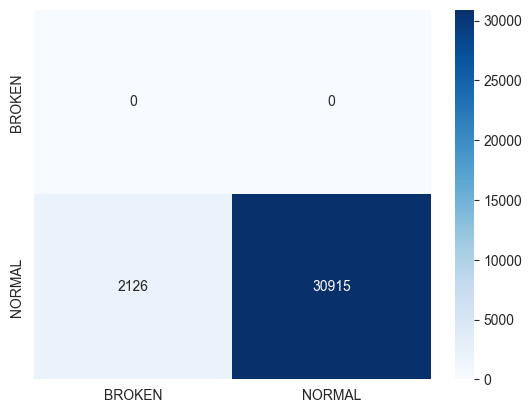

In [27]:
labels = np.unique(np.concatenate([y_test, y_pred]))
class_names = le.inverse_transform(labels)

cm = confusion_matrix(y_test, y_pred, labels=labels)

sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)

# 12. Inference on new data


In a real predictive maintenance system, we would receive a recent window
of sensor readings and need to predict the current machine status. This
section demonstrates how to run inference on a single window and interpret
the output.


In [28]:
def predict_status_from_sequence(sequence, model, label_encoder):
    """
    sequence: np.array of shape (WINDOW_SIZE, num_features)
    returns: predicted label (string) and class probabilities
    """
    sequence = np.expand_dims(sequence, axis=0)  # (1, window, features)
    probs = model.predict(sequence)[0]
    pred_idx = np.argmax(probs)
    pred_label = label_encoder.inverse_transform([pred_idx])[0]
    return pred_label, probs

# Example: use the first test sequence as a stand-in for new data
sample_idx = 0
pred_label, probs = predict_status_from_sequence(
    X_test[sample_idx],
    model,
    le
)

true_label = le.inverse_transform([y_test[sample_idx]])[0]

print("Predicted status:", pred_label)
print("True status     :", true_label)
print("\nClass probabilities:")
for cls, p in zip(le.classes_, probs):
    print(f"  {cls:10s}: {p:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted status: NORMAL
True status     : NORMAL

Class probabilities:
  BROKEN    : 0.001
  NORMAL    : 0.999
  RECOVERING: 0.000


In [29]:
# save trained model
model.save("trained_model.h5")

# 13. Conclusion

In this project, we built an LSTM-based predictive maintenance model for
industrial pumps using multivariate time-series sensor data.

**Key points:**

- **Problem & data:** The task was to classify the pump state
  (NORMAL / BROKEN / RECOVERING) from 52 sensor channels over time. The
  dataset is highly imbalanced, with NORMAL dominating.

- **Model:** We implemented a stacked LSTM network with dropout for
  regularization, trained on sliding windows of sensor readings.

- **Optimization techniques:**
  - We used **class-weighted loss** to reduce bias toward the majority
    NORMAL class.
  - We applied **early stopping** to prevent overfitting and keep the best
    validation weights.
  - We used **ReduceLROnPlateau** to automatically lower the learning rate
    when validation loss stopped improving, improving training stability.

- **Evaluation:** Besides accuracy, we reported **balanced accuracy** and
  **macro F1-score**, and analyzed the confusion matrix to understand how
  well the model detects BROKEN and RECOVERING states.

- **Limitations & future work:** Performance on minority classes is still
  constrained by the extreme imbalance and noise in sensor signals.
  Future improvements could include more advanced resampling, focal loss,
  or architectures like bidirectional LSTMs or GRUs, as well as additional
  domain-specific feature engineering.

Overall, the model demonstrates that LSTM-based sequence modeling with
proper optimization and imbalance handling can provide a useful signal for
predictive maintenance of industrial pumps.
